In [25]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model

In [26]:
# Funcs
def lag_dataset(df: pd.DataFrame, lags: int = 5, cols: list = None) -> pd.DataFrame:
    if cols is None:        
        cols = list(df.columns)
    
    X = pd.DataFrame(index=df.index)
    for i in range(1, lags+1):
        for col_name in cols:
            X[f"{col_name}_lag_{i}"] = df[col_name].shift(i)
    X.dropna(inplace=True)
    return X

In [27]:
msft = yf.Ticker("MSFT")
msft_df = msft.history(start="2010-01-01", end="2025-07-25", interval="1d")
msft_df = msft_df.drop(columns=["Dividends", "Stock Splits"])
msft_df.index = msft_df.index.tz_localize(None)

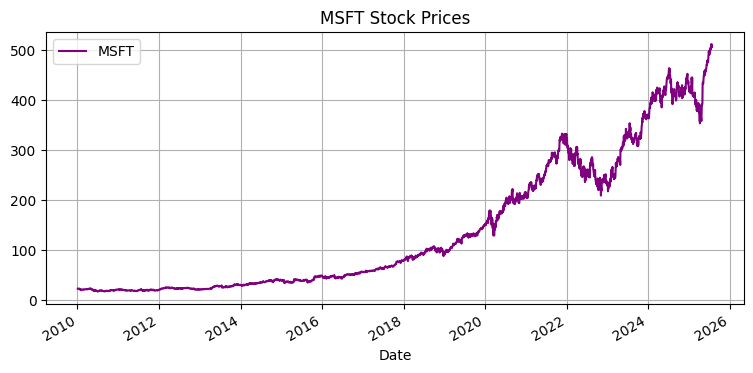

In [28]:
plt.subplots(figsize=(9, 4))
msft_df['Close'].plot(label='MSFT', color='purple')
plt.title('MSFT Stock Prices')
plt.grid()
plt.legend()

In [29]:
split_date = pd.Timestamp("2025-01-02")
train = msft_df["Close"].loc[: split_date - pd.Timedelta(days=1)]
test  = msft_df["Close"].loc[split_date :]
train_ret = 100 * train.pct_change().dropna()

<Axes: xlabel='Date'>

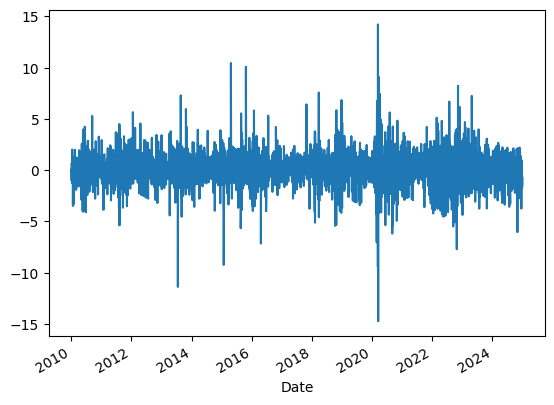

In [30]:
train_ret.plot()

In [31]:
cols = list(msft_df.columns)
cols.remove("Close")
exog_all = lag_dataset(msft_df, lags=5, cols=cols)

# 1. Genera exógenas y retornos
exog_all  = lag_dataset(msft_df, lags=5, cols=cols)
train_ret = 100 * train.pct_change()

# 2. Junta ambos en un solo DataFrame
df_train = pd.concat([train_ret.rename("ret"), exog_all], axis=1)

# 3. Elimino todas las filas con NaN
df_train = df_train.dropna()

# 4. Separo de nuevo
train_ret   = df_train["ret"]
exog_train  = df_train.drop(columns="ret")

In [32]:
am  = arch_model(train_ret, mean="ARX", lags=2, vol="Garch", p=1, q=1, dist="normal")
res = am.fit(disp="off")

print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                    ret   R-squared:                       0.007
Mean Model:                        AR   Adj. R-squared:                  0.006
Vol Model:                      GARCH   Log-Likelihood:               -6837.53
Distribution:                  Normal   AIC:                           13687.1
Method:            Maximum Likelihood   BIC:                           13724.5
                                        No. Observations:                 3767
Date:                Wed, Jul 30 2025   Df Residuals:                     3764
Time:                        11:30:21   Df Model:                            3
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.1201  2.404e-02      4.996  5.849e-

In [33]:
# —————— 5. Forecast estático multi‑step ——————
h  = len(test)
fc = res.forecast(horizon=h, reindex=False)

# fc.mean es un DataFrame de tamaño (t_obs)×h
# La última fila (iloc[-1]) contiene los retornos pronosticados one‑step:
ret_pred = fc.mean.iloc[-1].values / 100  # vector de longitud h, en fracción

# —————— 6. Reconstruye la serie de precios ——————
last_price = train.iloc[-1]
price_pred = (1 + pd.Series(ret_pred)).cumprod() * last_price
price_pred.index = test.index
price_pred.name = "GARCH Forecast"

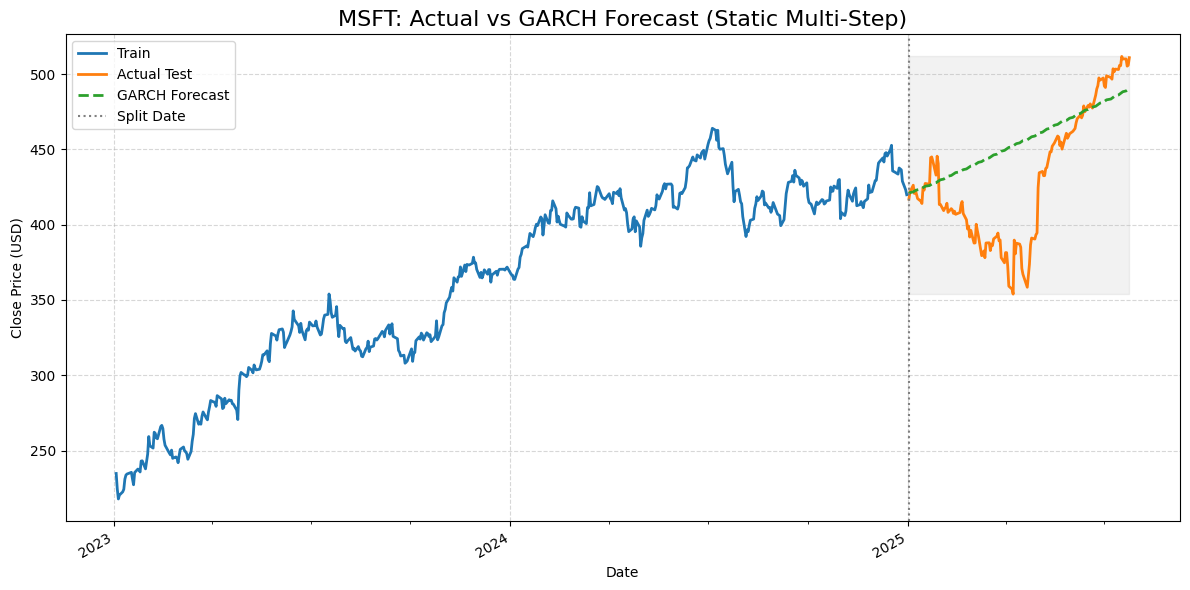

In [34]:
import matplotlib.dates as mdates

# —————— 7. Gráfico ——————
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train.loc["2023-01-01":], label="Train",        linewidth=2)
ax.plot(test,                label="Actual Test", linewidth=2)
ax.plot(price_pred,          label="GARCH Forecast", linestyle="--", linewidth=2)

ax.axvline(split_date, color="gray", linestyle=":", label="Split Date")
ax.fill_between(test.index, test.min(), test.max(), color="gray", alpha=0.1)

ax.set_title("MSFT: Actual vs GARCH Forecast (Static Multi-Step)", fontsize=16)
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")
ax.legend(loc="upper left")
ax.grid(True, linestyle="--", alpha=0.5)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

plt.tight_layout()